### Import Library dan Dataset

In [1]:
import os
import gc
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

In [2]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

I0000 00:00:1760588416.992024   35898 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1760588417.019641   35898 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1760588417.653892   35898 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Memory growth set error",e)

mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision policy:", mixed_precision.global_policy())

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070, compute capability 12.0
Mixed precision policy: <Policy "mixed_float16">


W0000 00:00:1760588418.917826   35898 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [4]:
tf.random.set_seed(42)
print("TensorFlow:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.21.0-dev20251013
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
df = pd.read_csv('./data/data_cleaned.csv')
df.head()

,Tweet,Label
0,asa i lop yuk pul monyetku cakepku sehat sehat...,Cinta
1,enggak enak banget bangun bangun badan panas,Sedih
2,aneh enggak sih padahal dia lebih sering kelua...,Marah
3,kasihan ceweknya pasti sedih banget dia ya kal...,Marah
4,ya kecewa,Sedih


### Persiapan Dataset

In [6]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])

# Splitting dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"].tolist(), df["LabelEncoded"].tolist(),
    test_size=0.3, stratify=df["LabelEncoded"], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

In [7]:
LOCAL_DIR = "./local-xlmr-tf" 
BATCH_SIZE = 8
MAX_LEN = 80
LR_CANDIDATES = [5e-6, 2e-5]
EPOCHS = 3

### Tokenisasi

In [8]:
# Mengambil Tokenizer dari model XLM-RoBERTa
tokenizer = AutoTokenizer.from_pretrained(LOCAL_DIR)


def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        return_tensors="tf"
    )


train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
W0000 00:00:1760588419.458659   35898 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1760588419.559356   35898 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


In [9]:
# Data Batching dan Batch Preparation
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.convert_to_tensor(train_labels)
)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(test_labels)
)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Fine-Tuning

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



Training with learning rate: 5e-06


All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at ./local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/3


E0000 00:00:1760588439.726541   35898 util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1760588442.126387   35997 service.cc:158] XLA service 0x7d13c636d6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760588442.126447   35997 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1760588442.130297   35997 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760588442.140030   35997 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1760588442.192747   35997 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


434/434 - 94s - loss: 1.3879 - accuracy: 0.4282 - val_loss: 0.8274 - val_accuracy: 0.7524 - 94s/epoch - 216ms/step
Epoch 2/3
434/434 - 62s - loss: 0.7075 - accuracy: 0.8038 - val_loss: 0.5749 - val_accuracy: 0.8170 - 62s/epoch - 143ms/step
Epoch 3/3
434/434 - 61s - loss: 0.5068 - accuracy: 0.8488 - val_loss: 0.5602 - val_accuracy: 0.8291 - 61s/epoch - 140ms/step
Validation Loss: 0.5602 | Validation Accuracy: 0.8291
Test Loss: 0.5553 | Test Accuracy: 0.8223


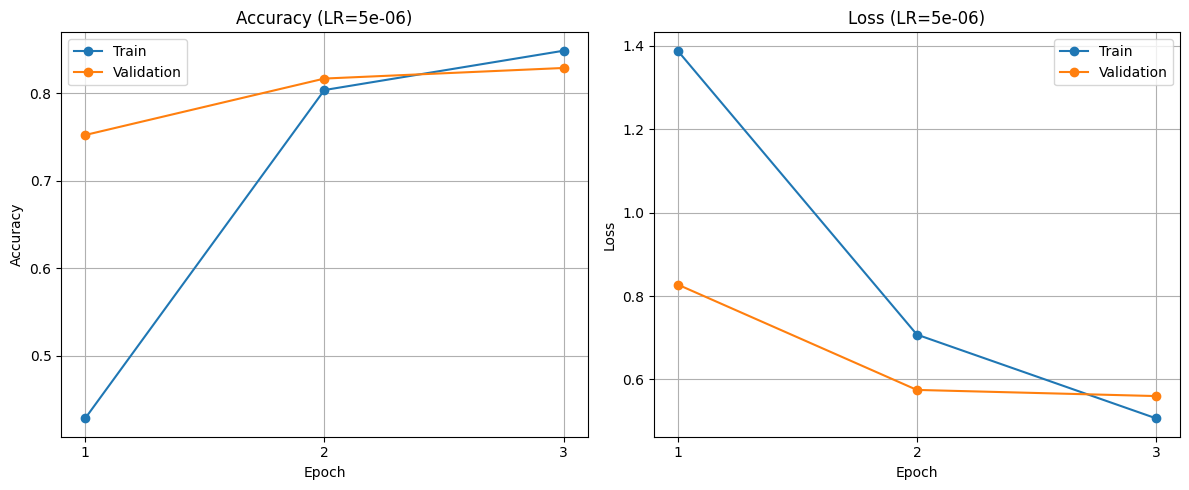


Training with learning rate: 2e-05


All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at ./local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


Epoch 1/3
434/434 - 92s - loss: 1.2670 - accuracy: 0.4815 - val_loss: 0.6958 - val_accuracy: 0.7954 - 92s/epoch - 212ms/step
Epoch 2/3
434/434 - 64s - loss: 0.6532 - accuracy: 0.8087 - val_loss: 0.6376 - val_accuracy: 0.7927 - 64s/epoch - 146ms/step
Epoch 3/3
434/434 - 61s - loss: 0.5241 - accuracy: 0.8428 - val_loss: 0.5222 - val_accuracy: 0.8143 - 61s/epoch - 141ms/step
Validation Loss: 0.5222 | Validation Accuracy: 0.8143
Test Loss: 0.5778 | Test Accuracy: 0.8102


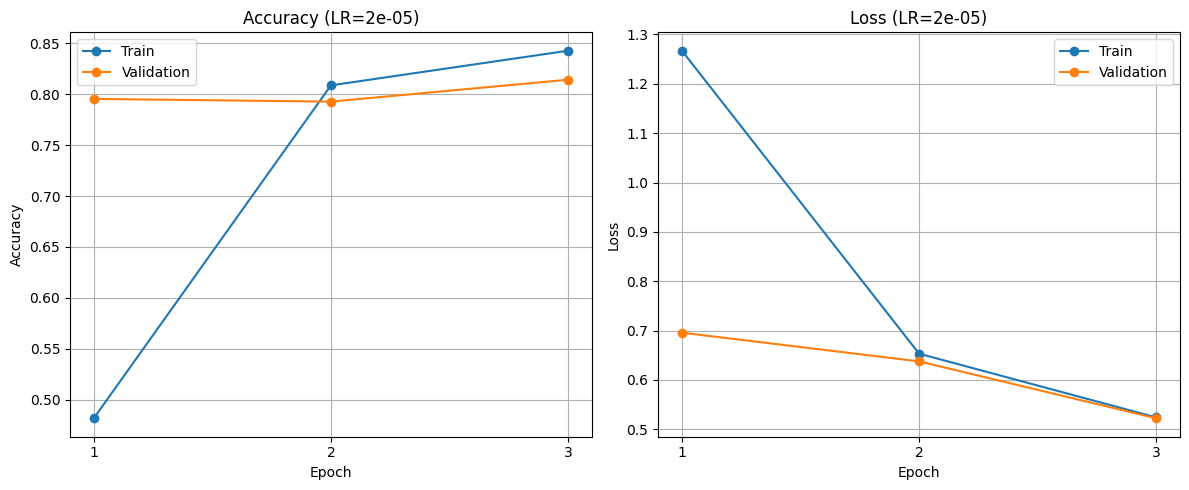

In [ ]:
# Menyiapkan Model untuk Fine-Tuning
num_labels = len(set(df["LabelEncoded"]))

results = []

for lr in LR_CANDIDATES:
    print("\n==============================")
    print(f"Training with learning rate: {lr}")
    print("==============================")

    # Bersihkan session agar variabel/optimizer lama tidak ‘nempel’
    tf.keras.backend.clear_session()
    gc.collect()

    # Load model dari folder lokal (offline)
    model = TFAutoModelForSequenceClassification.from_pretrained(
        LOCAL_DIR, num_labels=num_labels, local_files_only=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        verbose=2
    )

    # Evaluasi validasi untuk ringkasan
    val_loss, val_acc = model.evaluate(val_dataset, verbose=0)
    print(
        f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
    
    # Evaluasi testing
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    print(
        f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    # Simpan hasil ringkas
    results.append({
        "lr": lr,
        "val_loss": float(val_loss),
        "val_accuracy": float(val_acc),
        "test_loss": float(test_loss),
        "test_accuracy": float(test_acc)
    })
    
    # Menyimpan history berdasarkan test accuracy tertinggi
    if results[-1]['test_accuracy'] == max(r['test_accuracy'] for r in results):
        best_history = history
        best_model = model
        best_lr = lr

    # Visualisasi Learning Curve per LR
    epochs_num = np.arange(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(
        epochs_num, history.history['accuracy'], label='Train', marker='o')
    plt.plot(
        epochs_num, history.history['val_accuracy'], label='Validation', marker='o')
    plt.title(f'Accuracy (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, len(epochs_num) + 1, 1))
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_num, history.history['loss'], label='Train', marker='o')
    plt.plot(
        epochs_num, history.history['val_loss'], label='Validation', marker='o')
    plt.title(f'Loss (LR={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, len(epochs_num) + 1, 1))
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [11]:
results_df = pd.DataFrame(results)
print("\nSummary of Results:")
results_df


Summary of Results:


,lr,val_loss,val_accuracy,test_loss,test_accuracy
0,0.000005,0.560188,0.829071,0.555322,0.822342
1,0.000020,0.522241,0.814267,0.577830,0.810229


### Evaluasi

In [12]:
# Evaluasi best model pada test set
print(f"\nBest Learning Rate: {best_lr}")
model = best_model
pred_logits = model.predict(test_dataset).logits
pred_labels = np.argmax(pred_logits, axis=1)
true_labels = np.array(test_labels)
label_names = le.classes_.tolist()

print("\nClassification Report:")
print(classification_report(
    true_labels, 
    pred_labels,
    target_names=label_names, 
    digits=4))


Best Learning Rate: 5e-06
93/93 [==============================] - 7s 64ms/step

Classification Report:
              precision    recall  f1-score   support

       Cinta     0.6750    0.9558    0.7912       113
     Gembira     0.8701    0.8191    0.8438       188
       Marah     0.8562    0.7962    0.8251       157
       Sedih     0.8824    0.7047    0.7836       149
       Takut     0.8440    0.8750    0.8592       136

    accuracy                         0.8223       743
   macro avg     0.8255    0.8302    0.8206       743
weighted avg     0.8351    0.8223    0.8226       743



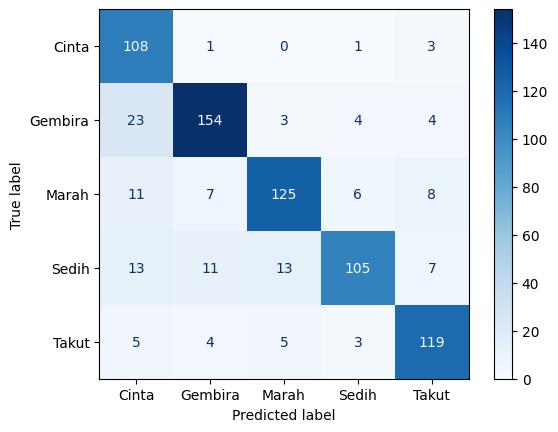

In [13]:
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)